# EDA & Data Transformation Tutorial

This notebook teaches you how to **explore** and **transform** data properly.
No modeling — just the skills that take up 80% of a data scientist's real work.

### How this works:
- Each section has a **lesson** (read + run) and an **exercise** (you write the code)
- Don't skip ahead — each section builds on the last

---

## Part 1: Exploration (IBM Stock Data)
We'll start with your IBM data to learn the fundamentals.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import kagglehub, os

path = kagglehub.dataset_download("dhrubangtalukdar/fortune-500-companies-stock-data")
ibm = pd.read_csv(os.path.join(path, "fortune_500_stock_data", "IBM.csv"))

/Users/chrisguarino/Documents/Programming/practice/env/lib/python3.14/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Lesson 1: First contact with your data

Every time you load a dataset, run these 4 things **before doing anything else**:

| Command | What it tells you |
|---------|-------------------|
| `.shape` | How many rows and columns |
| `.head()` | What the actual data looks like |
| `.dtypes` | What type each column is (number, string, date, etc.) |
| `.isnull().sum()` | How many missing values per column |

Run the next cell and **read the output carefully** before moving on.

In [2]:
print("SHAPE:", ibm.shape)
print("\nDTYPES:")
print(ibm.dtypes)
print("\nMISSING VALUES:")
print(ibm.isnull().sum())
print("\nFIRST 5 ROWS:")
ibm.head()

SHAPE: (2766, 7)

DTYPES:
Date              object
Open              object
High              object
Low               object
Close             object
Adjusted_Close    object
Volume            object
dtype: object

MISSING VALUES:
Date              1
Open              0
High              0
Low               0
Close             0
Adjusted_Close    0
Volume            0
dtype: int64

FIRST 5 ROWS:


,Date,Open,High,Low,Close,Adjusted_Close,Volume
0,NaN,IBM,IBM,IBM,IBM,IBM,IBM
1,2015-01-02,154.216064453125,156.12811279296875,153.91969299316406,154.93307495117188,98.12301635742188,5779673
2,2015-01-05,154.17782592773438,154.17782592773438,152.18930053710938,152.49522399902344,96.57909393310547,5104898
3,2015-01-06,152.64817810058594,152.92543029785156,148.34608459472656,149.2064971923828,94.49626922607422,6429448
4,2015-01-07,150.28680419921875,150.28680419921875,147.25621032714844,148.23135375976562,93.87866973876953,4918083


### What did you notice?

You should have caught something odd: every column is `object` (string) type,
even though Open/High/Low/Close/Volume are clearly numbers.

**Why?** Look at row 0 with `ibm.iloc[0]`. There's a string ("IBM") mixed into
the numeric columns. Pandas saw a mix of strings and numbers and defaulted
everything to `object`.

This is *extremely* common in real data. CSVs from APIs, scraped data, and
exported spreadsheets all have this kind of problem.

In [4]:
# See the problem row
ibm.iloc[0]

Date              NaN
Open              IBM
High              IBM
Low               IBM
Close             IBM
Adjusted_Close    IBM
Volume            IBM
Name: 0, dtype: object

### Lesson 2: Cleaning — fix types and bad rows

The cleaning recipe:
1. **Remove bad rows** — `iloc[1:]` to skip row 0
2. **Parse dates** — `pd.to_datetime()` turns strings into real dates
3. **Convert numbers** — `pd.to_numeric(errors='coerce')` turns strings to numbers (and bad values to NaN)
4. **Set the index** — for time series, the date should be the index, not a column

In [5]:
ibm = ibm.iloc[1:].copy()
ibm["Date"] = pd.to_datetime(ibm["Date"])
ibm = ibm.set_index("Date").sort_index()

for col in ibm.columns:
    ibm[col] = pd.to_numeric(ibm[col], errors="coerce")

# Verify: types should now be float64, no missing values
print("DTYPES after cleaning:")
print(ibm.dtypes)
print(f"\nMISSING: {ibm.isnull().sum().sum()} total")
print(f"SHAPE: {ibm.shape}")
ibm.head()

DTYPES after cleaning:
Open              float64
High              float64
Low               float64
Close             float64
Adjusted_Close    float64
Volume              int64
dtype: object

MISSING: 0 total
SHAPE: (2765, 6)


,Open,High,Low,Close,Adjusted_Close,Volume
Date,,,,,,
2015-01-02,154.216064,156.128113,153.919693,154.933075,98.123016,5779673
2015-01-05,154.177826,154.177826,152.189301,152.495224,96.579094,5104898
2015-01-06,152.648178,152.925430,148.346085,149.206497,94.496269,6429448
2015-01-07,150.286804,150.286804,147.256210,148.231354,93.878670,4918083
2015-01-08,149.369019,152.045883,148.709366,151.453156,95.919090,4431693


### Lesson 3: `.describe()` — your statistical X-ray

`.describe()` gives you 8 numbers per column. Here's what to look for:

| Stat | What to check |
|------|---------------|
| `count` | Does it match the number of rows? If not, you have nulls |
| `mean` vs `50%` | If they're far apart, the data is skewed |
| `min` / `max` | Are there impossible values? (negative prices, etc.) |
| `std` | How spread out is the data? Compare to the mean |
| `25%` vs `75%` | The middle 50% of data. Outliers live outside this range |

In [6]:
ibm.describe()

,Open,High,Low,Close,Adjusted_Close,Volume
count,2765.000000,2765.000000,2765.000000,2765.000000,2765.000000,2.765000e+03
mean,153.670107,155.006742,152.370002,153.744362,126.248798,4.793414e+06
std,42.061371,42.619732,41.583722,42.185388,51.576627,2.841299e+06
min,90.439774,93.441681,86.577438,90.602295,70.722755,1.186200e+06
25%,129.808792,130.650101,128.919693,129.789673,97.660500,3.281197e+06
50%,140.149994,141.013382,139.130005,140.143402,104.868156,4.093730e+06
75%,156.548752,157.695984,155.363297,156.424469,123.401619,5.342100e+06
max,319.890015,324.899994,314.529999,314.980011,314.980011,3.981442e+07


### Exercise 1: Answer these questions from `.describe()` output

Write your answers as comments in the cell below:
1. What's the price range IBM stock has traded in? (min Close to max Close)
2. Is Volume skewed? (compare mean to 50th percentile)
3. Which column has the biggest spread relative to its mean? (std/mean ratio)

In [ ]:
# YOUR ANSWERS HERE:
# 1. Price range: 90.602295 - 314.980011
# 2. Volume skewed? Mean is 4.793414e+06, but 50% is 4.093730e+06. They are very close. So the data in volume is reasonably spread NOT skewed. 
# 3. Biggest relative spread: Volume

### Lesson 4: Visualization — 4 essential plots

Numbers only go so far. These 4 plot types cover 90% of EDA:

1. **Line plot** — how does a value change over time?
2. **Histogram** — what does the distribution look like?
3. **Scatter plot** — how do two variables relate?
4. **Correlation heatmap** — which columns move together?

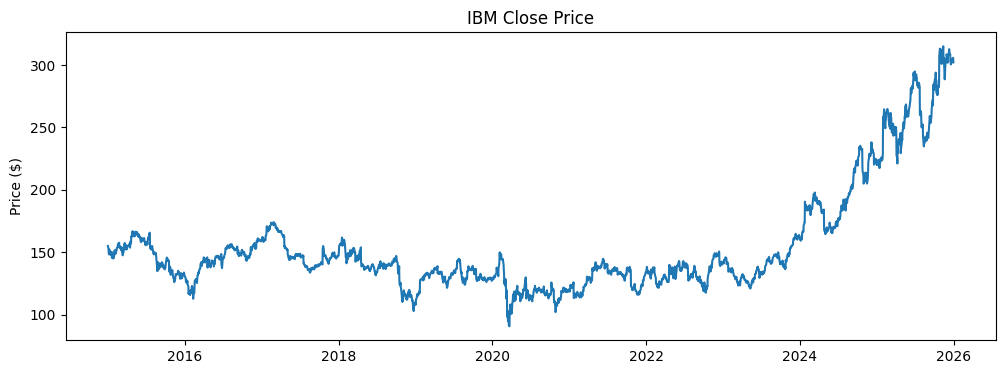

In [10]:
# 1. LINE PLOT — the bread and butter for time series
plt.figure(figsize=(12, 4))
plt.plot(ibm.index, ibm["Close"])
plt.title("IBM Close Price")
plt.ylabel("Price ($)")
plt.show()
# Notice: the price trends up and down over years.
# This means the data is NOT stationary (its statistics change over time).

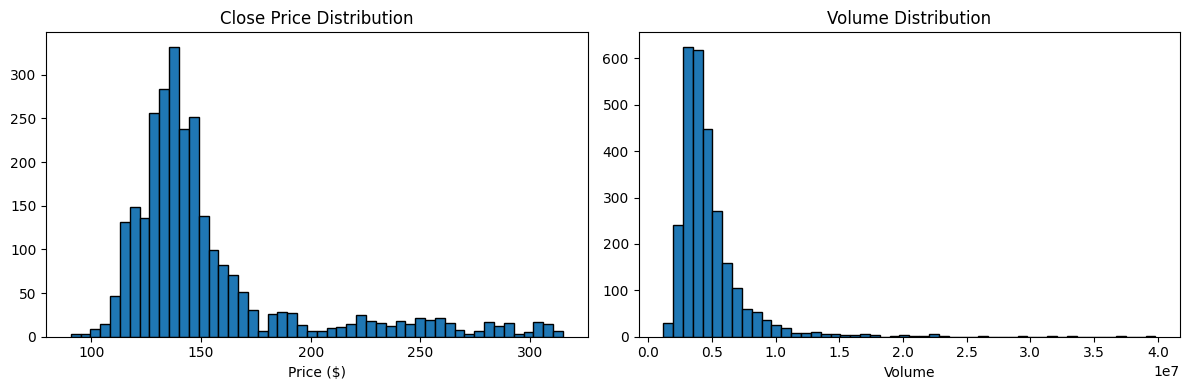

In [15]:
# 2. HISTOGRAM — shows the distribution of values
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(ibm["Close"], bins=50, edgecolor="black")
axes[0].set_title("Close Price Distribution")
axes[0].set_xlabel("Price ($)")

axes[1].hist(ibm["Volume"], bins=50, edgecolor="black")
axes[1].set_title("Volume Distribution")
axes[1].set_xlabel("Volume")

plt.tight_layout()
plt.show()
# Notice: Volume has a long right tail (right-skewed).
# A few days had extremely high volume — could be earnings days or news events.

In [ ]:
# 3. SCATTER PLOT — relationship between two variables
plt.figure(figsize=(6, 5))
plt.scatter(ibm["Volume"], ibm["Close"], alpha=0.2, s=5)
plt.xlabel("Volume")
plt.ylabel("Close Price ($)")
plt.title("Volume vs Close Price")
plt.show()
# No clear linear relationship — high volume happens at all price levels.

In [ ]:
# 4. CORRELATION HEATMAP — which columns move together?
corr = ibm[["Open", "High", "Low", "Close", "Volume"]].corr()

fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(corr, cmap="coolwarm", vmin=-1, vmax=1)
ax.set_xticks(range(len(corr.columns)))
ax.set_yticks(range(len(corr.columns)))
ax.set_xticklabels(corr.columns, rotation=45)
ax.set_yticklabels(corr.columns)

# Add correlation values as text
for i in range(len(corr)):
    for j in range(len(corr)):
        ax.text(j, i, f"{corr.iloc[i, j]:.2f}", ha="center", va="center", fontsize=9)

plt.colorbar(im)
plt.title("Feature Correlations")
plt.tight_layout()
plt.show()
# Open/High/Low/Close are ~0.99 correlated — they're almost the same information.
# Volume is weakly correlated with price — it's actually independent info.

### Exercise 2: Make your own plots

In the cell below, create:
1. A line plot of **Volume** over time
2. A histogram of **daily returns** (hint: `ibm['Close'].pct_change()` gives you daily % change)

After plotting, write a comment describing what you see.

In [ ]:
# YOUR CODE HERE:


### Lesson 5: Common transformations

Raw data is rarely in the right shape. Here are the most common transformations:

| Transformation | When to use it | pandas method |
|---------------|----------------|---------------|
| **Lag/shift** | When past values matter | `.shift(n)` |
| **Rolling window** | Smooth out noise, capture trends | `.rolling(n).mean()` |
| **Percent change** | Compare relative changes across different scales | `.pct_change()` |
| **Log transform** | Reduce right skew in distributions | `np.log()` |
| **Binning** | Turn continuous values into categories | `pd.cut()` or `pd.qcut()` |

In [ ]:
# SHIFT: creates a lagged version of a column
# shift(1) = "yesterday's value"
# shift(-1) = "tomorrow's value" (useful for creating prediction targets)

demo = ibm[["Close"]].head(10).copy()
demo["Close_yesterday"] = demo["Close"].shift(1)
demo["Close_tomorrow"] = demo["Close"].shift(-1)
demo
# Notice: shift(1) has NaN in the first row (no "yesterday" for the first day)
# shift(-1) has NaN in the last row (no "tomorrow" for the last day)

In [ ]:
# ROLLING: computes a statistic over a sliding window
# Great for smoothing noisy data and spotting trends

plt.figure(figsize=(12, 4))
plt.plot(ibm.index, ibm["Close"], alpha=0.3, label="Raw Close")
plt.plot(ibm.index, ibm["Close"].rolling(20).mean(), label="20-day MA", linewidth=2)
plt.plot(ibm.index, ibm["Close"].rolling(100).mean(), label="100-day MA", linewidth=2)
plt.legend()
plt.title("Moving Averages smooth out daily noise")
plt.ylabel("Price ($)")
plt.show()

In [ ]:
# PCT_CHANGE: converts absolute values to relative changes
# This is critical because a $5 move means different things at $100 vs $300

ibm["Return"] = ibm["Close"].pct_change()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(ibm.index, ibm["Close"])
axes[0].set_title("Raw Close Price (non-stationary)")
axes[0].set_ylabel("Price ($)")

axes[1].plot(ibm.index, ibm["Return"])
axes[1].set_title("Daily Returns (closer to stationary)")
axes[1].set_ylabel("Return")

plt.tight_layout()
plt.show()
# Key insight: raw price trends up/down, but returns fluctuate around 0.
# Models generally work better on stationary data.

In [ ]:
# LOG TRANSFORM: compresses right-skewed distributions
# Perfect for Volume, which has a long right tail

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(ibm["Volume"], bins=50, edgecolor="black")
axes[0].set_title("Volume (raw) — right-skewed")

axes[1].hist(np.log(ibm["Volume"]), bins=50, edgecolor="black")
axes[1].set_title("log(Volume) — more normal")

plt.tight_layout()
plt.show()

In [ ]:
# BINNING: turns continuous values into categories
# pd.cut = equal-width bins, pd.qcut = equal-count bins

ibm["Volume_category"] = pd.qcut(ibm["Volume"], q=3, labels=["Low", "Medium", "High"])
print(ibm["Volume_category"].value_counts())
print()

# Useful for: groupby analysis
print("Average Close price by volume category:")
print(ibm.groupby("Volume_category")["Close"].mean())

### Exercise 3: Transform the data yourself

In the cell below:
1. Create a column called `Range` that is `High - Low` (the daily price range)
2. Create a 10-day rolling standard deviation of `Close` (call it `Volatility`)
3. Plot `Volatility` over time — when was IBM stock most volatile?

In [ ]:
# YOUR CODE HERE:


---

## Part 2: Messier Data (Titanic Dataset)

IBM stock was relatively clean. Real-world data is much worse.
The Titanic dataset has everything that makes data messy:
- **Missing values** (lots of them)
- **Mixed types** (numbers, strings, categories)
- **Categorical data** that needs encoding
- **Outliers**
- **Columns that need engineering** to be useful

In [ ]:
# Titanic dataset — built into most data science setups
url = "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv"
titanic = pd.read_csv(url)

# First contact — always run these 4
print("SHAPE:", titanic.shape)
print("\nDTYPES:")
print(titanic.dtypes)
print("\nMISSING VALUES:")
print(titanic.isnull().sum())
print("\nFIRST 5 ROWS:")
titanic.head()

### Lesson 6: Handling missing values

Three strategies, each appropriate in different situations:

| Strategy | When to use it | Method |
|----------|---------------|--------|
| **Drop rows** | Very few missing values, or the row is mostly empty | `.dropna()` |
| **Drop column** | Most values are missing (>50%), or the column isn't useful | `.drop(columns=...)` |
| **Fill/impute** | The column is important and you can make a reasonable guess | `.fillna()` |

Common fills:
- **Numeric**: mean (if symmetric) or median (if skewed)
- **Categorical**: mode (most common value) or a new category like "Unknown"

In [ ]:
# Let's see what's missing and decide what to do
missing = titanic.isnull().sum()
missing_pct = (missing / len(titanic) * 100).round(1)
print("Missing values:")
print(pd.DataFrame({"count": missing, "percent": missing_pct}).query("count > 0"))

# Cabin: 77% missing -> DROP the column
# Age: 20% missing -> FILL with median (age is skewed)
# Embarked: 0.2% missing -> FILL with mode (most common port)

In [ ]:
df = titanic.copy()

# Drop Cabin (too much missing data to be useful)
df = df.drop(columns=["Cabin"])

# Fill Age with median
print(f"Age median: {df['Age'].median()}")
df["Age"] = df["Age"].fillna(df["Age"].median())

# Fill Embarked with mode
print(f"Embarked mode: {df['Embarked'].mode()[0]}")
df["Embarked"] = df["Embarked"].fillna(df["Embarked"].mode()[0])

print(f"\nRemaining missing values: {df.isnull().sum().sum()}")

### Lesson 7: Working with categorical data

Models need numbers. Categorical columns (Sex, Embarked) need to be converted.

| Method | When to use it | Example |
|--------|---------------|--------|
| **Label encoding** | 2 categories (binary) | Male=0, Female=1 |
| **One-hot encoding** | 3+ categories with no order | Embarked -> 3 binary columns |
| **Ordinal encoding** | Categories with a natural order | Low < Medium < High |

In [ ]:
# Label encoding for binary: Sex
df["Sex_encoded"] = df["Sex"].map({"male": 0, "female": 1})

# One-hot encoding: Embarked (S, C, Q -> 3 binary columns)
embarked_dummies = pd.get_dummies(df["Embarked"], prefix="Embarked")
print("One-hot encoded Embarked:")
print(embarked_dummies.head())

# You can join these back to your dataframe
df = pd.concat([df, embarked_dummies], axis=1)

### Lesson 8: GroupBy — the most powerful EDA tool

`.groupby()` lets you split your data into groups and compute stats per group.
This is how you find patterns and answer questions like:
- "Did women survive more than men?"
- "Did 1st class passengers have better survival rates?"

In [ ]:
# Survival rate by Sex
print("Survival rate by Sex:")
print(df.groupby("Sex")["Survived"].mean().round(3))

print("\nSurvival rate by Pclass:")
print(df.groupby("Pclass")["Survived"].mean().round(3))

print("\nSurvival rate by Sex AND Pclass:")
print(df.groupby(["Sex", "Pclass"])["Survived"].mean().round(3))

# Key insight: women in 1st/2nd class survived at ~90-97%.
# Men in 3rd class survived at ~13%. The pattern is clear.

In [ ]:
# .agg() lets you compute MULTIPLE stats at once
print("Age statistics by class:")
df.groupby("Pclass")["Age"].agg(["mean", "median", "std", "count"])

### Exercise 4: Explore the Titanic data

In the cell below:
1. What was the average fare by passenger class? (use `.groupby()`)
2. Create a histogram of Age, colored by Survived (hint: use two `.hist()` calls with `alpha=0.5`)
3. What percentage of passengers were in each Embarked port? (hint: `.value_counts(normalize=True)`)

In [ ]:
# YOUR CODE HERE:


### Exercise 5: Feature engineering on Titanic

Create these new columns from existing data:
1. `FamilySize` = `SibSp` + `Parch` + 1 (siblings/spouses + parents/children + self)
2. `IsAlone` = 1 if FamilySize == 1, else 0
3. `Title` = extract the title (Mr, Mrs, Miss, etc.) from the `Name` column
   (hint: `df['Name'].str.extract(r' ([A-Za-z]+)\.')` pulls out the title)

Then use `.groupby('Title')['Survived'].mean()` to see which titles survived most.

In [ ]:
# YOUR CODE HERE:


---

## Cheat Sheet: pandas methods you should memorize

### Exploration
| Method | Purpose |
|--------|---------|
| `.shape` | Rows x columns |
| `.head()` / `.tail()` | First/last rows |
| `.dtypes` | Column types |
| `.info()` | Types + null counts + memory |
| `.describe()` | Summary statistics |
| `.isnull().sum()` | Missing value counts |
| `.value_counts()` | Frequency of unique values |
| `.corr()` | Correlation matrix |
| `.nunique()` | Number of unique values per column |

### Transformation
| Method | Purpose |
|--------|---------|
| `.fillna()` | Fill missing values |
| `.dropna()` | Drop rows/columns with nulls |
| `.astype()` | Convert column types |
| `.map()` / `.replace()` | Remap values |
| `.apply()` | Apply a function to each row/column |
| `.shift()` | Lag values |
| `.rolling()` | Sliding window calculations |
| `.pct_change()` | Percent change |
| `pd.cut()` / `pd.qcut()` | Bin continuous values |
| `pd.get_dummies()` | One-hot encode categories |
| `.groupby().agg()` | Split-apply-combine |
| `.str.extract()` | Extract patterns from strings |